## Code for Runoff analysis over CONUS404 based estimation in comparison with USGS-CAMELS datasets

### Author: Miguel Diaz

#### **Libraries**

!pip install absl-py apache-beam xarray xarray-beam earthengine-api geemap pyproj geopandas pandas numpy sparse hvplot holoviews dask cf-xarray geoviews pynhd hydrofunctions intake cartopy shapely matplotlib contextily scipy rasterio requests IPython
!pip install notebook
!earthengine authenticate
!pip install dask[distributed]
!pip install bokeh
!pip install xee
!pip install datashader

!pip install zarr
!pip install fsspec gcsfs s3fs
!pip install --upgrade intake
!pip install zarr intake intake-xarray fsspec s3fs gcsfs
!pip install --upgrade intake intake-xarray zarr
!pip install metpy

!pip install --upgrade xarray metpy
!pip install scikit-learn
!pip install apache-beam
!pip install cf_xarray

In [1]:
import logging
import os
import time
import warnings
import webbrowser

# Data handling and computation
import numpy as np
import pandas as pd
import xarray as xr
import cf_xarray
import dask
import dask.array as da
from dask import delayed
from dask.distributed import Client
import sparse

# Scientific libraries
import pyproj
from scipy.stats import linregress, gumbel_r

# GIS and remote sensing
import geopandas as gpd
import geemap
import ee
import xarray_beam as xbeam
import apache_beam as beam
import xee
import zarr

# Mapping and visualization
import hvplot.pandas
import hvplot.xarray
import holoviews as hv
from holoviews.operation.datashader import rasterize
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import plotly.express as px

# Geospatial libraries
from shapely.geometry import Polygon
from rasterio.enums import Resampling

# Hydrology and water data
from pynhd import NLDI, WaterData
import hydrofunctions as hf

# Data intake and registry
import intake
print(intake.registry)

# Meteorology and weather data
from metpy.units import units
import metpy  # Ensure this is imported to extend xarray

# Web and API requests
import requests
from IPython.display import HTML

# ABSL (Google's command-line flags and app framework)
from absl import app, flags

# Ensure inline plotting for Jupyter notebooks
%matplotlib inline


<Intake driver registry>


#### **CONUS 404 - SOURCES**

This section contains notebooks that demonstrate how to access and perform basic data manipulation for the [CONUS404 dataset](https://doi.org/10.5066/P9PHPK4F). The examples can also be applied to the [CONUS404 bias-adjusted dataset](https://doi.org/10.5066/P9JE61P7).

In the CONUS404 intake sub-catalog (see [here](../dataset_catalog/README.md) for an explainer of our intake data catalog), you will see entries for four CONUS404 datasets: `conus404-hourly`, `conus404-daily`, `conus404-monthly`, and `conus404-daily-diagnostic` data, as well as two CONUS404 bias-adjusted datasets: `conus404-hourly-ba`, `conus404-daily-ba`. Each of these datasets is duplicated in up to three different storage locations (as the [intake catalog section](../dataset_catalog/README.md) also describes).

In the CONUS404 intake sub-catalog (see [here](../dataset_catalog/README.md) for an explainer of our intake data catalog), you will see entries for:
- four CONUS404 datasets: `conus404-hourly`, `conus404-daily`, `conus404-monthly`, and `conus404-daily-diagnostic` data
- two CONUS404 bias-adjusted datasets: `conus404-hourly-ba`, `conus404-daily-ba`
- two CONUS404 PGW datasets: `conus404-pgw-hourly` and `conus404-pgw-daily-diagnostic`

#### **Dask client with specified number of workers**

In [2]:
client = Client(n_workers=4)  
client

C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 59184 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:59187' processes=4 threads=32, memory=127.69 GiB>

Open the hytest data intake catalog


In [3]:
# "https://raw.githubusercontent.com/hytest-org/hytest/main/dataset_catalog/hytest_intake_catalog.yml"
hytest_cat = intake.open_catalog("https://raw.githubusercontent.com/hytest-org/hytest/main/dataset_catalog/hytest_intake_catalog.yml")
list(hytest_cat)

['conus404-catalog',
 'benchmarks-catalog',
 'conus404-drb-eval-tutorial-catalog',
 'nhm-v1.0-daymet-catalog',
 'nhm-v1.1-c404-bc-catalog',
 'nhm-v1.1-gridmet-catalog',
 'trends-and-drivers-catalog',
 'nhm-prms-v1.1-gridmet-format-testing-catalog',
 'nwis-streamflow-usgs-gages-onprem',
 'nwis-streamflow-usgs-gages-osn',
 'nwm21-streamflow-usgs-gages-onprem',
 'nwm21-streamflow-usgs-gages-osn',
 'nwm21-streamflow-cloud',
 'geofabric_v1_1-zip-osn',
 'geofabric_v1_1_POIs_v1_1-osn',
 'geofabric_v1_1_TBtoGFv1_POIs-osn',
 'geofabric_v1_1_nhru_v1_1-osn',
 'geofabric_v1_1_nhru_v1_1_simp-osn',
 'geofabric_v1_1_nsegment_v1_1-osn',
 'gages2_nndar-osn',
 'wbd-zip-osn',
 'huc12-geoparquet-osn',
 'huc12-gpkg-osn',
 'nwm21-scores',
 'lcmap-cloud',
 'rechunking-tutorial-osn',
 'pointsample-tutorial-sites-osn',
 'pointsample-tutorial-output-osn']

Open the conus404 sub-catalog

In [4]:
cat = hytest_cat['conus404-catalog']
list(cat)

['conus404-hourly-onprem-hw',
 'conus404-hourly-cloud',
 'conus404-hourly-osn',
 'conus404-daily-diagnostic-onprem-hw',
 'conus404-daily-diagnostic-cloud',
 'conus404-daily-diagnostic-osn',
 'conus404-daily-onprem-hw',
 'conus404-daily-cloud',
 'conus404-daily-osn',
 'conus404-monthly-onprem-hw',
 'conus404-monthly-cloud',
 'conus404-monthly-osn',
 'conus404-hourly-ba-onprem-hw',
 'conus404-hourly-ba-osn',
 'conus404-daily-ba-onprem',
 'conus404-daily-ba-osn',
 'conus404-pgw-hourly-onprem-hw',
 'conus404-pgw-hourly-osn',
 'conus404-pgw-daily-diagnostic-onprem-hw',
 'conus404-pgw-daily-diagnostic-osn',
 'conus404-pgw-daily-onprem-hw',
 'conus404-pgw-daily-osn']

**CONUS404 dataset**

Select the dataset you want to read into your notebook and preview its metadata

In [5]:
#  conus404-daily-osn
dataset = 'conus404-daily-osn' 
#dataset = 'nhm-v1.1-c404-bc-byHRU-onprem-hw'
cat[dataset]

In [6]:
print(f"Reading {dataset} metadata...", end='')
ds = cat[dataset].to_dask().metpy.parse_cf()
print("done")

Reading conus404-daily-osn metadata...done


Select time frame to read ("CONUS404 goes from 1979 and 2021")

In [7]:
ds_conus = ds.sel(time=slice('1989-10-01','2010-09-30')) # ========> (Water year WY1990 - WY 2021)
ds

<xarray.Dataset> Size: 9TB
Dimensions:         (y: 1015, x: 1367, time: 15707, bottom_top_stag: 51,
                     bottom_top: 50, soil_layers_stag: 4, x_stag: 1368,
                     y_stag: 1016, snow_layers_stag: 3, snso_layers_stag: 7)
Coordinates:
    lat             (y, x) float32 6MB dask.array<chunksize=(350, 350), meta=np.ndarray>
    lon             (y, x) float32 6MB dask.array<chunksize=(350, 350), meta=np.ndarray>
  * time            (time) datetime64[ns] 126kB 1979-10-01 ... 2022-10-01
  * x               (x) float64 11kB -2.732e+06 -2.728e+06 ... 2.732e+06
  * y               (y) float64 8kB -2.028e+06 -2.024e+06 ... 2.028e+06
    metpy_crs       object 8B Projection: lambert_conformal_conic
    lat_u           (y, x_stag) float32 6MB dask.array<chunksize=(350, 175), meta=np.ndarray>
    lon_u           (y, x_stag) float32 6MB dask.array<chunksize=(350, 175), meta=np.ndarray>
    lat_v           (y_stag, x) float32 6MB dask.array<chunksize=(175, 350), meta=np.ndarray>
    lon_v           (y_stag, x) float32 6MB dask.array<chunksize=(175, 350), meta=np.ndarray>
Dimensions without coordinates: bottom_top_stag, bottom_top, soil_layers_stag,
                                x_stag, y_stag, snow_layers_stag,
                                snso_layers_stag
Data variables: (12/153)
    ACDEWC          (time, y, x) float32 87GB dask.array<chunksize=(36, 350, 350), meta=np.ndarray>
    ACDRIPR         (time, y, x) float32 87GB dask.array<chunksize=(36, 350, 350), meta=np.ndarray>
    ACDRIPS         (time, y, x) float32 87GB dask.array<chunksize=(36, 350, 350), meta=np.ndarray>
    ACECAN          (time, y, x) float32 87GB dask.array<chunksize=(36, 350, 350), meta=np.ndarray>
    ACEDIR          (time, y, x) float32 87GB dask.array<chunksize=(36, 350, 350), meta=np.ndarray>
    ACETLSM         (time, y, x) float32 87GB dask.array<chunksize=(36, 350, 350), meta=np.ndarray>
    ...              ...
    ZNU             (bottom_top) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    ZNW             (bottom_top_stag) float32 204B dask.array<chunksize=(51,), meta=np.ndarray>
    ZS              (soil_layers_stag) float32 16B dask.array<chunksize=(4,), meta=np.ndarray>
    ZSNSO           (time, snso_layers_stag, y, x) float32 610GB dask.array<chunksize=(36, 7, 350, 350), meta=np.ndarray>
    ZWT             (time, y, x) float32 87GB dask.array<chunksize=(36, 350, 350), meta=np.ndarray>
    crs             int64 8B ...
Attributes: (12/148)
    AER_ANGEXP_OPT:                  1
    AER_ANGEXP_VAL:                  1.2999999523162842
    AER_AOD550_OPT:                  1
    AER_AOD550_VAL:                  0.11999999731779099
    AER_ASY_OPT:                     1
    AER_ASY_VAL:                     0.8999999761581421
    ...                              ...
    WEST-EAST_PATCH_START_STAG:      1
    WEST-EAST_PATCH_START_UNSTAG:    1
    W_DAMPING:                       1
    YSU_TOPDOWN_PBLMIX:              0
    history:                         Tue Mar 29 16:35:22 2022: ncrcat -A -vW ...
    history_of_appended_files:       Tue Mar 29 16:35:22 2022: Appended file ...

**Variables selection ( There is a list of variables) - (Tab ds_conus)**

ds_conus

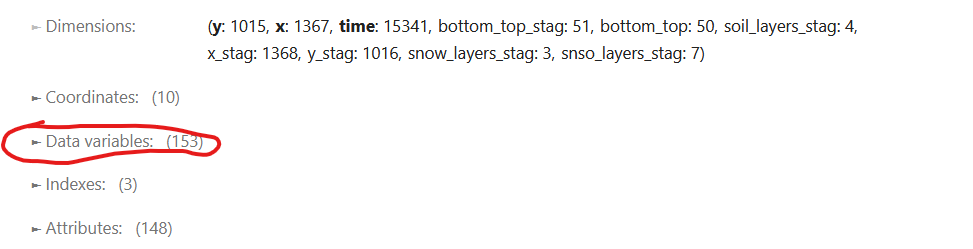
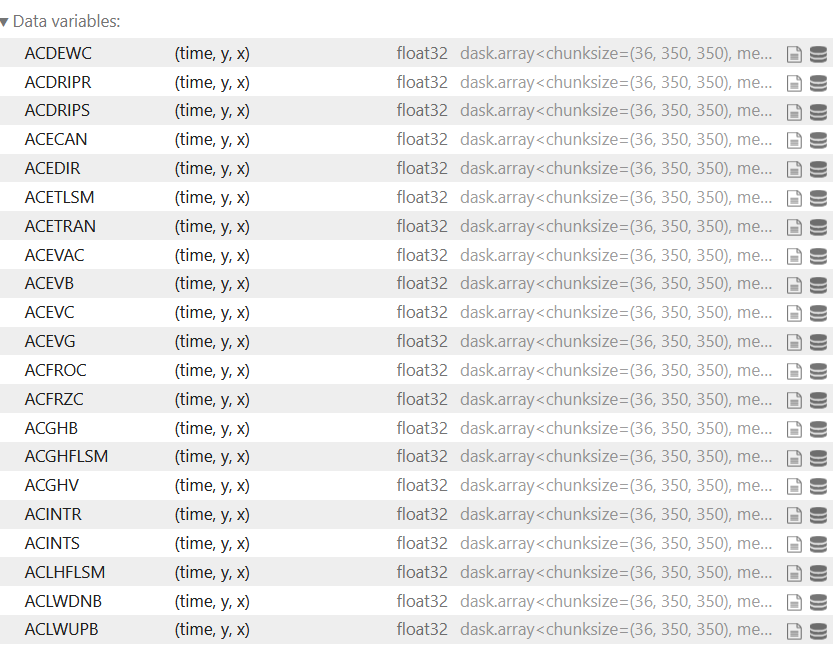

### **Model WRF CONUS404 Scheme**


In general terms for the water balance:

$$
\text{residual} = \left(P - ET - \text{srfoff} + \text{qlat} - \text{qrf} \right) - \Delta (\text{SMCWTD} + \text{SMC} + \text{CANWAT} + \text{SNOW} + \text{WA})
$$

where:

- P = total incoming precipitation  
- ET = total evapotranspiration  
- srfoff= surface runoff  
- qlat= lateral groundwater flow  
- qrf = groundwater discharge to river  
- SMCWTD = soil moisture in the auxiliary layer (between the 2-m soil layer and the groundwater)  
- SMC = soil moisture in the 2-m soil layer  
- CANWAT = water stored in the canopy  
- SNOW = snow water equivalent in the snowpack  
- WA = water stored in the aquifer  




In CONUS404 variable names:

$$
\text{residual} = \text{ACRAINLSM} + \text{ACSNOWLSM} - \text{ACECAN} - \text{ACETRAN} - \text{ACEDIR} - \text{ACRUNSF} + \text{ACQLAT} - \text{ACQRF} - \Delta(\text{QSPRINGS}) - \Delta(\text{SMCWTD}_{\text{calculated}} + \text{SMOIS}_{\text{calculated}} + \text{CANWAT} + \text{SNOW} + \text{WA}_{\text{calculated}})
$$

where:

- SMOIS_calculated is SMOIS (volumetric soi moisture content) converted to depth in mm by multiplying by soil layer depths (100mm, 300mm, 600mm, 1000mm)

- SMCWTD_calculated is the water in the zone between the 2-m soil column and the lower of the water table or the bottom of the 1-m auxiliary layer, calculated as  SMCWTD*(-2 – min(ZWT, -3))*1000

- WA_calculated is the water in the saturated zone below the auxiliary later calculated as SMCMAX*(min(ZWT, -3)-ZBEDROCK)*1000



### **Runoff Analysis**

Total runoff is ACRUNSF (quickflow-ish) + ACQRF (baseflow-ish).

In [8]:
%%time

# # Process the dataset
# ds_conus_Runoff = ds_conus[['ACRUNSF']].resample(time="YE").sum()
# Q_Runoff = ds_conus_Runoff.rio.write_crs(ds_conus.crs.metpy.cartopy_crs).compute()

# Select dataset within the given time range
ds_conus_Runoff = ds_conus[['ACRUNSF']]

# Resample using 'AS-OCT' to align with the water year
ds_conus_Runoff_WY = ds_conus_Runoff.resample(time="AS-OCT", label="right").sum()

# Compute the final result
Q_Runoff = ds_conus_Runoff_WY.rio.write_crs(ds_conus.crs.metpy.cartopy_crs).compute()

C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\xarray\groupers.py:487: FutureWarning: 'AS-OCT' is deprecated and will be removed in a future version, please use 'YS-OCT' instead.
  self.index_grouper = pd.Grouper(


CPU times: total: 53.7 s
Wall time: 7min 50s


In [9]:
%%time
# ds_conus_baseflow = ds_conus[['ACQRF']].resample(time="YE").sum()
# Baseflow_sub = ds_conus_baseflow.rio.write_crs(ds_conus.crs.metpy.cartopy_crs).compute()

# Select dataset within the given time range
ds_conus_baseflow = ds_conus[['ACQRF']]

# Resample using 'AS-OCT' to align with the water year
ds_conus_baseflow_WY = ds_conus_baseflow.resample(time="AS-OCT", label="right").sum()

# Compute the final result
Baseflow_sub = ds_conus_baseflow_WY.rio.write_crs(ds_conus.crs.metpy.cartopy_crs).compute()

C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\xarray\groupers.py:487: FutureWarning: 'AS-OCT' is deprecated and will be removed in a future version, please use 'YS-OCT' instead.
  self.index_grouper = pd.Grouper(


CPU times: total: 1min
Wall time: 10min 11s


Visualize data computed

In [10]:
Baseflow_sub.hvplot.quadmesh(x='x', y='y', rasterize=True, geo=True, tiles='OSM', alpha=0.7, cmap='turbo')

:DynamicMap   [time]
   :Overlay
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .Image.I :Image   [x,y]   (Accumulated groundwater baseflow)

Data agregation to estimate total runoff (ACRUNSF+ ACQRF)

In [11]:
ds_subset_Runoff = Q_Runoff['ACRUNSF']
ds_subset_Baseflow = Baseflow_sub['ACQRF']

Runoff_CONUS404 = ds_subset_Runoff + ds_subset_Baseflow 

Runoff_CONUS404 = Runoff_CONUS404.to_dataset(name="Runoff") # ==> New band to store the aggregation

Runoff_CONUS404 = Runoff_CONUS404.rio.write_crs(Runoff_CONUS404.crs.metpy.cartopy_crs).drop_vars(['lat', 'lon']).compute()

Runoff_CONUS404 = Runoff_CONUS404.rio.reproject('EPSG:4326')

In [12]:
Runoff_CONUS404

<xarray.Dataset> Size: 128MB
Dimensions:    (y: 1015, x: 1367, time: 21)
Coordinates:
    lat        (y, x) float32 6MB 17.65 17.66 17.67 17.68 ... 51.73 51.71 51.69
    lon        (y, x) float32 6MB -122.6 -122.5 -122.5 ... -57.17 -57.12 -57.07
  * x          (x) float64 11kB -2.732e+06 -2.728e+06 ... 2.728e+06 2.732e+06
  * y          (y) float64 8kB -2.028e+06 -2.024e+06 ... 2.024e+06 2.028e+06
    metpy_crs  object 8B Projection: lambert_conformal_conic
  * time       (time) datetime64[ns] 168B 1990-10-01 1991-10-01 ... 2010-10-01
    crs        int32 4B 0
Data variables:
    Runoff     (time, y, x) float32 117MB 0.0 0.0 0.0 0.0 ... 12.59 11.92 11.39

#### **Sanford_AET**

Reading C:\Users\adi10136\OneDrive - Iowa State University\Desktop\CONUS404\ET Sanford\AET\Processed\AET_1990.tif with Dask...
Dataset structure: <xarray.DataArray (band: 1, y: 681, x: 1608)> Size: 4MB
dask.array<where, shape=(1, 681, 1608), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 13kB -124.7 -124.7 -124.6 ... -67.04 -67.01 -66.97
  * y            (y) float64 5kB 49.38 49.34 49.31 49.27 ... 25.02 24.98 24.95
    spatial_ref  int32 4B 0
    time         int32 4B 1990
Attributes: (12/14)
    AREA_OR_POINT:           Area
    RepresentationType:      ATHEMATIC
    STATISTICS_COUNT:        632066.0
    STATISTICS_COVARIANCES:  54896.16113315563
    STATISTICS_MAXIMUM:      1419.3394775391
    STATISTICS_MEAN:         521.58686652417
    ...                      ...
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       234.29929819177
    _FillValue:    

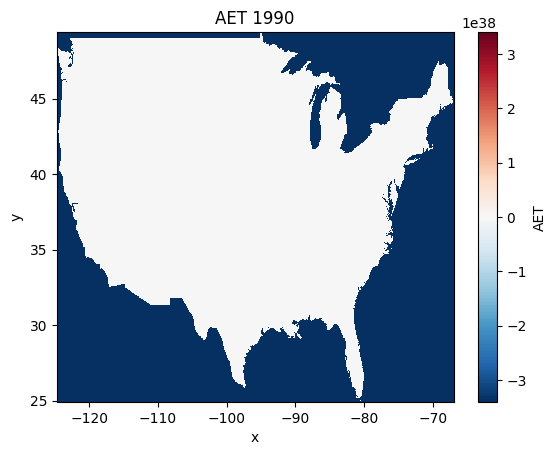

In [91]:
import xarray as xr
import rioxarray  # For raster handling
import dask.array as da  # Enable Dask for parallel computing
import os
import matplotlib.pyplot as plt

# Define the directory containing raster files
raster_dir = r"C:\Users\adi10136\OneDrive - Iowa State University\Desktop\CONUS404\ET Sanford\AET\Processed"

# Define the year range of interest
year_range = range(1990, 2010)  # Modify as needed

# List to store individual raster datasets
datasets = []

# Loop through each year, locate the corresponding raster file, and load it with Dask
for year in year_range:
    raster_path = os.path.join(raster_dir, f"AET_{year}.tif")
    
    if os.path.exists(raster_path):  # Check if file exists
        print(f"Reading {raster_path} with Dask...", end="")
        
        # Open raster with Dask-enabled chunking
        ds = rioxarray.open_rasterio(raster_path, chunks={"x": 512, "y": 512})
        
        # Assign a time coordinate
        ds = ds.assign_coords(time=year)
        
        # Handle NoData values (mask them)
        nodata_value = -3.4028235e+38  # NoData value from ArcGIS
        ds = ds.where(ds != nodata_value)

        # Print dataset structure to identify variable names
        print("\nDataset structure:", ds)

        # Ensure data is correctly aligned (selecting first band if necessary)
        if "band" in ds.dims:
            ds = ds.isel(band=0, drop=True)  # Drop "band" dimension

        # Rename the DataArray directly to "AET"
        ds = ds.rename("AET")  

        datasets.append(ds)
        print("done")
    else:
        print(f"File not found: {raster_path}")

# Merge datasets if any were loaded
if datasets:
    ds_combined = xr.concat(datasets, dim="time")

    # ✅ Subset the dataset (similar to `ds_conus[['ACQRF']]`)
    ds_aet_only = ds_combined  # Already renamed to "AET"

    print(ds_aet_only)

    # Compute the dataset to load data into memory (optional)
    ds_aet_only = ds_aet_only.compute()  # Remove this line to keep it lazy

    # Plot the first year's raster to verify
    ds_aet_only.sel(time=year_range.start).plot()
    plt.title(f"AET {year_range.start}")
    plt.show()
else:
    print("No datasets were loaded.")
    

In [92]:
ds_AET_Sanford = ds_aet_only
ds_AET_Sanford

<xarray.DataArray 'AET' (time: 20, y: 681, x: 1608)> Size: 88MB
array([[[-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
        [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
        [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
        ...,
        [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
        [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
        [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38]],

       [[-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
        [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
        [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
...
        [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
        [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
        [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38]],

       [[-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
        [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
        [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
        ...,
        [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
        [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
        [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38]]], dtype=float32)
Coordinates:
  * x            (x) float64 13kB -124.7 -124.7 -124.6 ... -67.04 -67.01 -66.97
  * y            (y) float64 5kB 49.38 49.34 49.31 49.27 ... 25.02 24.98 24.95
    spatial_ref  int32 4B 0
  * time         (time) int32 80B 1990 1991 1992 1993 ... 2006 2007 2008 2009
Attributes: (12/14)
    AREA_OR_POINT:           Area
    RepresentationType:      ATHEMATIC
    STATISTICS_COUNT:        632066.0
    STATISTICS_COVARIANCES:  54896.16113315563
    STATISTICS_MAXIMUM:      1419.3394775391
    STATISTICS_MEAN:         521.58686652417
    ...                      ...
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       234.29929819177
    _FillValue:              -3.4028235e+38
    scale_factor:            1.0
    add_offset:              0.0

In [93]:
import xarray as xr

# NoData value from metadata
nodata_value = -3.4028235e+38

# ✅ Convert the DataArray to a Dataset and rename the variable
ds_AET_Sanford = ds_AET_Sanford.to_dataset(name="AET")

# ✅ Mask NoData values (if not already masked)
ds_AET_Sanford = ds_AET_Sanford.where(ds_AET_Sanford != nodata_value)

# ✅ Now, you can subset it like `ds_conus[['ACRUNSF']]`
Sandfor_AET = ds_AET_Sanford[['AET']]

print(Sandfor_AET)

<xarray.Dataset> Size: 88MB
Dimensions:      (time: 20, y: 681, x: 1608)
Coordinates:
  * x            (x) float64 13kB -124.7 -124.7 -124.6 ... -67.04 -67.01 -66.97
  * y            (y) float64 5kB 49.38 49.34 49.31 49.27 ... 25.02 24.98 24.95
    spatial_ref  int32 4B 0
  * time         (time) int32 80B 1990 1991 1992 1993 ... 2006 2007 2008 2009
Data variables:
    AET          (time, y, x) float32 88MB -3.403e+38 -3.403e+38 ... -3.403e+38


In [94]:
# # Multiply the 'AET' variable by 1000 to convert from meters to millimeters
# Sandfor_AET["AET"] = Sandfor_AET["AET"] * 1000


print(Sandfor_AET["AET"].min().values, Sandfor_AET["AET"].max().values)


-3.4028235e+38 1949.5167


Sandfor_AET.hvplot.quadmesh(x='x', y='y', rasterize=True, geo=True, tiles='OSM', alpha=0.7, cmap='turbo')

In [95]:
import xarray as xr

# ✅ Step 1: Extract the CRS from `Runoff_CONUS404`
if "crs" not in Runoff_CONUS404:
    raise ValueError("Error: `Runoff_CONUS404` does not contain a `crs` DataArray!")

crs_dataarray = Runoff_CONUS404["crs"]  # Extract CRS DataArray

# ✅ Step 2: Assign the CRS DataArray to `Sandfor_AET`
Sandfor_AET = Sandfor_AET.assign(crs=crs_dataarray)  # Add CRS as a new DataArray

# ✅ Step 3: Verify the CRS assignment
print(Sandfor_AET["crs"])  # Should now match `Runoff_CONUS404["crs"]`
print("✅ CRS successfully assigned to `Sandfor_AET` as an `xarray.DataArray`!")


<xarray.DataArray 'crs' ()> Size: 4B
array(0)
Coordinates:
    spatial_ref  int32 4B 0
    metpy_crs    object 8B Projection: lambert_conformal_conic
Attributes: (12/17)
    crs_wkt:                        PROJCS["unknown",GEOGCS["unknown",DATUM["...
    semi_major_axis:                6370000.0
    semi_minor_axis:                6370000.0
    inverse_flattening:             0.0
    reference_ellipsoid_name:       unknown
    longitude_of_prime_meridian:    0.0
    ...                             ...
    standard_parallel:              (30.0, 50.0)
    latitude_of_projection_origin:  39.1000061035156
    longitude_of_central_meridian:  -97.9000015258789
    false_easting:                  0.0
    false_northing:                 0.0
    spatial_ref:                    PROJCS["unknown",GEOGCS["unknown",DATUM["...
✅ CRS successfully assigned to `Sandfor_AET` as an `xarray.DataArray`!


In [96]:
# ✅ Step 1: Check if `rio.crs` exists
if Sandfor_AET.rio.crs:
    # ✅ Step 2: Explicitly drop the CRS attributes
    Sandfor_AET = Sandfor_AET.drop_vars("spatial_ref", errors="ignore")  # Remove spatial_ref if present
    Sandfor_AET.attrs.pop("crs", None)  # Remove 'crs' from attributes
    Sandfor_AET.attrs.pop("crs_wkt", None)  # Remove 'crs_wkt' if exists

# ✅ Step 3: Verify that `rio.crs` is removed
print("Updated CRS:", Sandfor_AET.rio.crs)
print("✅ `rio.crs` successfully removed from `Sandfor_AET`!")


Updated CRS: None
✅ `rio.crs` successfully removed from `Sandfor_AET`!


import xarray as xr
import rioxarray  # For raster handling
import os
import matplotlib.pyplot as plt

# Define the directory containing raster files
raster_dir = "C:/Users/adi10136/OneDrive - Iowa State University/Desktop/CONUS404/ET Sanford/AET"

# Define the year range of interest
year_range = range(1990, 2010)  # Modify as needed

# NoData value from metadata
nodata_value = -3.4028235e+38

# List to store individual raster datasets
datasets = []

# Loop through each year, locate the corresponding raster file, and load it
for year in year_range:
    raster_path = os.path.join(raster_dir, f"AET_{year}.tif")
    
    if os.path.exists(raster_path):  # Check if file exists
        print(f"Reading {raster_path} with Dask...", end="")
        
        # Open raster lazily with Dask
        ds = rioxarray.open_rasterio(raster_path, chunks={"x": 512, "y": 512})
        
        # Assign a time coordinate
        ds = ds.assign_coords(time=year)

        # Drop band dimension since there is only one band
        if "band" in ds.dims:
            ds = ds.isel(band=0, drop=True)

        # Mask NoData values
        ds = ds.where(ds != nodata_value)

        # Rename the data variable to "AET"
        ds = ds.rename("AET")

        datasets.append(ds)
        print("done")
    else:
        print(f"File not found: {raster_path}")

# Merge datasets if any were loaded
if datasets:
    ds_combined = xr.concat(datasets, dim="time")

    # ✅ Subset like `ds_conus[['ACRUNSF']]`
    ds_aet_only = ds_combined.to_dataset(name="AET")  # Convert DataArray to Dataset

    print(ds_aet_only)

    # Compute if needed
    ds_aet_only = ds_aet_only.compute()

    # Plot the first year's raster to verify
    ds_aet_only["AET"].sel(time=year_range.start).plot()
    plt.title(f"AET for {year_range.start}")
    plt.show()

    # Now you can use it like this:
    ds_Sanford_AET = ds_aet_only[["AET"]]  # ✅ Works like ds_conus[['ACRUNSF']]
    print(ds_Sanford_AET)
else:
    print("No datasets were loaded.")


In [97]:
import xarray as xr

# ✅ Step 1: Ensure 'crs' is not in data variables but is moved to coordinates
if "crs" in Sandfor_AET.data_vars:
    crs_variable = Sandfor_AET["crs"]  # Extract CRS data

    # ✅ Step 2: Assign 'crs' as a coordinate
    Sandfor_AET = Sandfor_AET.assign_coords(crs=crs_variable)

    # ✅ Step 3: Remove 'crs' from data variables
    Sandfor_AET = Sandfor_AET.drop_vars("crs")

# ✅ Step 4: Ensure 'crs' is set up like `Runoff_CONUS404`
if "crs" not in Sandfor_AET.coords:
    Sandfor_AET = Sandfor_AET.assign_coords(crs=Runoff_CONUS404["crs"])

# ✅ Step 5: Ensure 'crs' is correctly formatted in coordinates
Sandfor_AET["crs"].attrs = Runoff_CONUS404["crs"].attrs

# ✅ Step 6: Verify that 'crs' is in the correct position
print(Sandfor_AET)

print("✅ CRS successfully moved to coordinates, matching `Runoff_CONUS404`!")



<xarray.Dataset> Size: 88MB
Dimensions:    (time: 20, y: 681, x: 1608)
Coordinates:
  * x          (x) float64 13kB -124.7 -124.7 -124.6 ... -67.04 -67.01 -66.97
  * y          (y) float64 5kB 49.38 49.34 49.31 49.27 ... 25.02 24.98 24.95
  * time       (time) int32 80B 1990 1991 1992 1993 1994 ... 2006 2007 2008 2009
    metpy_crs  object 8B Projection: lambert_conformal_conic
    crs        int32 4B 0
Data variables:
    AET        (time, y, x) float32 88MB -3.403e+38 -3.403e+38 ... -3.403e+38
✅ CRS successfully moved to coordinates, matching `Runoff_CONUS404`!


In [98]:
Sandfor_AET.hvplot(x='x', y='y', rasterize=True, cmap='viridis', frame_width=600, tiles='OpenTopoMap', title='Accumulated actual evapotranspiration in mm (1990-2010) Sanford', alpha=0.5)

:DynamicMap   [time]
   :Overlay
      .Tiles.I :Tiles   [x,y]
      .Image.I :Image   [x_,y_]   (AET)

In [99]:
Sandfor_AET

<xarray.Dataset> Size: 88MB
Dimensions:    (time: 20, y: 681, x: 1608)
Coordinates:
  * x          (x) float64 13kB -124.7 -124.7 -124.6 ... -67.04 -67.01 -66.97
  * y          (y) float64 5kB 49.38 49.34 49.31 49.27 ... 25.02 24.98 24.95
  * time       (time) int32 80B 1990 1991 1992 1993 1994 ... 2006 2007 2008 2009
    metpy_crs  object 8B Projection: lambert_conformal_conic
    crs        int32 4B 0
Data variables:
    AET        (time, y, x) float32 88MB -3.403e+38 -3.403e+38 ... -3.403e+38

#### **CAMELS geometry of gages catchments from NLDI**

Initialize the NLDI service

In [73]:
nldi = NLDI()
# print(nldi)

List of gages included in CAMEL dataset

https://gdex.ucar.edu/dataset/camels/file.html 


In [74]:
gage_ids = ["01013500", "01019000", "01022500", "01030500", "01031500", "01038000", "01047000", "01052500", "01054200", "01055000", "01057000", "01064500", "01073000", "01073500", "01078000", "01094500", "01096000", "01097000", "01102000", "01104500", "01109000", "01109060", "01111500", "01116000", "01116500", "01118300", "01118500", "01119500", "01121000", "01123000", "01127500", "01129200", "01134500", "01137500", "01139000", "01139800", "01142500", "01144000", "01151500", "01152500", "01162500", "01166500", "01168500", "01169000", "01170100", "01171500", "01174500", "01176000", "01181000", "01185500", "01186000", "01186500", "01187300", "01193500", "01195100", "01196500", "01197000", "01197500", "01204000", "01208500", "01315000", "01331500", "01333000", "01334000", "01336000", "01350000", "01350080", "01350140", "01365000", "01367500", "01372500", "01380500", "01388000", "01388500", "01391500", "01395000", "01396800", "01397000", "01400000", "01401000", "01402000", "01405400", "01408000", "01408500", "01409400", "01410000", "01411000", "01411300", "01411500", "01413500", "01414500", "01415000", "01420500", "01423000", "01429000", "01429500", "01431500", "01434025", "01435000", "01439500", "01440000", "01440400", "01442500", "01445500", "01447500", "01447720", "01449360", "01450500", "01451500", "01451800", "01452000", "01452500", "01457000", "01464000", "01464500", "01465500", "01466500", "01467000", "01467048", "01469500", "01470500", "01472157", "01473000", "01474000", "01477000", "01479000", "01480000", "01480500", "01484100", "01485500", "01486000", "01487000", "01491000", "01495000", "01500000", "01509000", "01510000", "01516500", "01518862", "01523500", "01524500", "01532000", "01534000", "01536000", "01538000", "01539000", "01541000", "01541200", "01541500", "01542810", "01543000", "01543500", "01544000", "01544500", "01545000", "01545600", "01546500", "01547500", "01547700", "01547950", "01548500", "01549500", "01550000", "01552000", "01552500", "01555000", "01555500", "01556000", "01557500", "01558000", "01560000", "01564500", "01567500", "01568000", "01571500", "01573000", "01574500", "01576500", "01580000", "01582000", "01583500", "01586000", "01586610", "01591400", "01594950", "01595200", "01596500", "01599000", "01601500", "01604500", "01605500", "01606500", "01607500", "01613050", "01616500", "01619500", "01620500", "01625000", "01626000", "01632000", "01632900", "01634500", "01635500", "01637500", "01638480", "01639000", "01639500", "01643500", "01644000", "01645000", "01646000", "01648000", "01649500", "01651000", "01653600", "01658500", "01664000", "01666500", "01667500", "01669000", "01669520", "01673800", "01674000", "02011400", "02011460", "02013000", "02014000", "02015700", "02016000", "02017500", "02018000", "02021500", "02027000", "02027500", "02028500", "02038850", "02039000", "02039500", "02041000", "02042500", "02044500", "02046000", "02051000", "02051500", "02053200", "02053500", "02053800", "02054500", "02055100", "02056900", "02058400", "02059500", "02064000", "02065500", "02069700", "02070000", "02073000", "02074500", "02077200", "02081500", "02082950", "02085500", "02088000", "02090380", "02091000", "02092500", "02094500", "02096846", "02100500", "02102908", "02108000", "02111180", "02111500", "02112120", "02112360", "02113000", "02113850", "02114450", "02118000", "02118500", "02125000", "02128000", "02133500", "02137727", "02138500", "02140991", "02143000", "02143040", "02143500", "02146600", "02149000", "02152100", "02169570", "02177000", "02178400", "02193340", "02196000", "02198100", "02202600", "02212600", "02213500", "02215100", "02216180", "02221525", "02231000", "02231342", "02235200", "02245500", "02246000", "02296500", "02297155", "02297310", "02298123", "02298608", "02299950", "02300700", "02310947", "02312200", "02314500", "02315500", "02324400", "02327100", "02331600", "02333500", "02335700", "02336300", "02337000", "02341800", "02342500", "02342933", "02344500", "02344700", "02349900", "02350900", "02361000", "02363000", "02369800", "02371500", "02372250", "02374500", "02380500", "02381600", "02384540", "02385800", "02395120", "02398000", "02399200", "02401390", "02408540", "02415000", "02422500", "02427250", "02430085", "02430615", "02450000", "02450250", "02464000", "02464146", "02464360", "02465493", "02469800", "02471001", "02472000", "02472500", "02473500", "02475500", "02476500", "02476600", "02479130", "02479155", "02479300", "02479560", "02481000", "02481510", "02484000", "03010655", "03011800", "03014500", "03015500", "03020500", "03021350", "03026500", "03028000", "03034000", "03034500", "03038000", "03042000", "03042280", "03042500", "03045000", "03049000", "03049800", "03050000", "03053500", "03061500", "03066000", "03069500", "03070500", "03072000", "03074500", "03076500", "03076600", "03078000", "03079000", "03080000", "03085500", "03091500", "03093000", "03102850", "03106000", "03108000", "03110000", "03111500", "03112000", "03117500", "03118000", "03118500", "03136500", "03140000", "03145000", "03157000", "03159540", "03161000", "03164000", "03165000", "03167000", "03170000", "03173000", "03180500", "03182500", "03186500", "03187500", "03202400", "03207800", "03208500", "03208950", "03209000", "03213700", "03217000", "03220000", "03228500", "03232500", "03237280", "03237500", "03238500", "03240000", "03241500", "03262000", "03264000", "03272000", "03275600", "03280700", "03281100", "03281500", "03283500", "03285000", "03291780", "03294000", "03300400", "03302800", "03303300", "03310300", "03320500", "03324000", "03325500", "03329700", "03330500", "03333450", "03334500", "03338780", "03340800", "03342500", "03343400", "03346000", "03347000", "03350700", "03351500", "03353500", "03357350", "03358000", "03361650", "03361850", "03362000", "03363500", "03364500", "03366500", "03368000", "03369500", "03375500", "03378000", "03378550", "03378635", "03382100", "03384450", "03438000", "03439000", "03446000", "03450000", "03451000", "03455500", "03456500", "03459500", "03460000", "03463300", "03471500", "03473000", "03479000", "03488000", "03491000", "03498500", "03500000", "03500240", "03504000", "03512000", "03531500", "03550000", "03574500", "03592718", "03604000", "03612000", "04015330", "04024430", "04027000", "04027500", "04036000", "04037500", "04040500", "04043050", "04045500", "04056500", "04057510", "04057800", "04059500", "04063700", "04074950", "04087120", "04087220", "04093000", "04094000", "04096405", "04099510", "04101800", "04102700", "04105000", "04105700", "04108600", "04108800", "04109000", "04112500", "04115265", "04117500", "04121300", "04122200", "04122500", "04124000", "04127918", "04127997", "04128990", "04142000", "04155000", "04161540", "04161580", "04164500", "04166500", "04168000", "04180000", "04185000", "04186500", "04189000", "04196800", "04197100", "04197170", "04201500", "04202000", "04207200", "04213000", "04213075", "04214500", "04215500", "04216418", "04221000", "04224775", "04230500", "04233000", "04234000", "04239000", "04243500", "04252500", "04256000", "04258000", "04262500", "04280000", "04282000", "04285500", "04287000", "04288000", "04289000", "04292000", "04296000", "04296500", "05017500", "05056000", "05057000", "05057200", "05062500", "05078230", "05087500", "05101000", "05120500", "05123400", "05129115", "05130500", "05131500", "05291000", "05315000", "05362000", "05370000", "05393500", "05394500", "05397500", "05399500", "05406500", "05408000", "05412500", "05413500", "05414000", "05414820", "05419000", "05429500", "05431486", "05444000", "05451900", "05452200", "05454000", "05454300", "05458000", "05463000", "05466000", "05466500", "05470500", "05481950", "05487980", "05488200", "05489000", "05495000", "05495500", "05501000", "05503800", "05506800", "05507600", "05508805", "05512500", "05514500", "05516500", "05522500", "05525500", "05527800", "05529000", "05536000", "05536190", "05536275", "05536290", "05539000", "05540095", "05540500", "05543830", "05548280", "05551200", "05551700", "05556500", "05568800", "05577500", "05579500", "05580000", "05584500", "05585000", "05587900", "05591550", "05592050", "05592575", "05593575", "05593900", "05594450", "05595730", "06037500", "06043500", "06061500", "06154400", "06154410", "06169500", "06188000", "06191500", "06211000", "06211500", "06216000", "06221400", "06224000", "06278300", "06280300", "06289000", "06291500", "06298000", "06309200", "06311000", "06332515", "06339100", "06339500", "06342260", "06342450", "06344600", "06350000", "06352000", "06353000", "06354000", "06360500", "06402000", "06402500", "06404000", "06406000", "06408700", "06409000", "06410500", "06422500", "06431500", "06440200", "06441500", "06447000", "06447500", "06449000", "06450500", "06452000", "06453600", "06464500", "06468170", "06468250", "06470800", "06477500", "06478540", "06478690", "06479215", "06479438", "06600100", "06601000", "06614800", "06622700", "06623800", "06625000", "06632400", "06647500", "06712000", "06746095", "06784000", "06800000", "06803000", "06803510", "06803520", "06803530", "06804000", "06806500", "06814000", "06847900", "06853800", "06871500", "06876700", "06878000", "06879650", "06884200", "06885500", "06888500", "06889200", "06889500", "06892000", "06893500", "06894000", "06903400", "06903700", "06906800", "06910800", "06911900", "06912500", "06915000", "06917000", "06918440", "06918460", "06918740", "06919500", "06921070", "06921200", "06932000", "06934000", "07014500", "07017200", "07050700", "07056000", "07057500", "07060710", "07066000", "07067000", "07068000", "07071500", "07083000", "07103700", "07126200", "07142300", "07145700", "07148400", "07149000", "07151500", "07167500", "07169800", "07179500", "07179795", "07180500", "07184000", "07191220", "07195800", "07196900", "07197000", "07203000", "07207000", "07207500", "07208500", "07216500", "07218000", "07226500", "07230000", "07247500", "07249400", "07261000", "07263295", "07264000", "07274000", "07283000", "07290650", "07291000", "07292500", "07295000", "07299670", "07301410", "07301500", "07315200", "07315700", "07325800", "07326000", "07335700", "07337900", "07340300", "07343000", "07346045", "07352000", "07359610", "07361500", "07362100", "07362587", "07373000", "07375000", "07376000", "07376500", "07383500", "08013000", "08014500", "08017200", "08017300", "08019500", "08023080", "08025500", "08028000", "08029500", "08041700", "08050800", "08061540", "08063100", "08063800", "08064700", "08065200", "08066170", "08066200", "08066300", "08069000", "08070000", "08070200", "08070500", "08074500", "08076000", "08079600", "08082700", "08083100", "08086212", "08086290", "08101000", "08103900", "08104900", "08109700", "08109800", "08110100", "08150800", "08155200", "08158600", "08158700", "08158810", "08164000", "08164300", "08164600", "08164800", "08165300", "08171000", "08171300", "08172400", "08175000", "08176900", "08178800", "08178880", "08189500", "08189700", "08190000", "08190500", "08194200", "08195000", "08196000", "08198000", "08198500", "08200000", "08202700", "08255500", "08265000", "08267500", "08269000", "08271000", "08275500", "08276300", "08279000", "08291000", "08324000", "08377900", "08378500", "08380500", "08387000", "08401900", "08405500", "09034900", "09035800", "09035900", "09037500", "09047500", "09047700", "09050100", "09050700", "09059500", "09063000", "09065500", "09066000", "09066200", "09066300", "09073400", "09080400", "09081600", "09107000", "09112500", "09124500", "09146200", "09172500", "09210500", "09223000", "09255000", "09277500", "09289500", "09292500", "09306242", "09310500", "09312600", "09326500", "09330500", "09337500", "09342500", "09352900", "09372000", "09378170", "09378630", "09386900", "09390500", "09404450", "09409880", "09430500", "09430600", "09442680", "09447800", "09480000", "09484000", "09484600", "09492400", "09494000", "09497800", "09497980", "09504500", "09505200", "09505350", "09505800", "09507980", "09508300", "09510200", "09512280", "09513780", "09513860", "10011500", "10023000", "10032000", "10109000", "10128500", "10131000", "10134500", "10137500", "10166430", "10172700", "10172800", "10173450", "10174500", "10194200", "10205030", "10234500", "10242000", "10244950", "10249300", "10258000", "10258500", "10259000", "10259200", "10263500", "10293000", "10296000", "10296500", "10308200", "10309000", "10310000", "10310500", "10316500", "10329500", "10336645", "10336660", "10336740", "10343500", "10344400", "10344500", "10348850", "10349300", "10352500", "10396000", "11012500", "11015000", "11022480", "11025500", "11028500", "11042400", "11065000", "11073360", "11077500", "11098000", "11109600", "11118500", "11123000", "11123500", "11124500", "11132500", "11141280", "11143000", "11143200", "11143250", "11147500", "11148900", "11149900", "11151300", "11152000", "11156500", "11160000", "11160500", "11162500", "11176400", "11176500", "11180500", "11180960", "11200800", "11224500", "11230500", "11237500", "11253310", "11264500", "11266500", "11274500", "11274630", "11284400", "11299600", "11345500", "11376550", "11379500", "11381500", "11383500", "11390000", "11402000", "11413000", "11424000", "11427000", "11451100", "11458000", "11461000", "11468000", "11468500", "11473900", "11475560", "11476600", "11478500", "11480390", "11481200", "11482500", "11521500", "11522500", "11523200", "11528700", "11532500", "12010000", "12013500", "12020000", "12025000", "12025700", "12035000", "12036000", "12040500", "12041200", "12043000", "12048000", "12054000", "12056500", "12073500", "12082500", "12086500", "12092000", "12093500", "12095000", "12112600", "12114500", "12115000", "12115500", "12117000", "12141300", "12142000", "12143600", "12144000", "12144500", "12145500", "12147500", "12147600", "12148500", "12167000", "12175500", "12178100", "12186000", "12189500", "12332000", "12335500", "12342500", "12358500", "12374250", "12375900", "12377150", "12381400", "12383500", "12388400", "12390700", "12411000", "12414500", "12414900", "12447390", "12451000", "12452800", "12488500", "12502500", "13011500", "13011900", "13018300", "13023000", "13052200", "13075000", "13083000", "13120000", "13161500", "13174500", "13200000", "13235000", "13239000", "13240000", "13310700", "13313000", "13331500", "13337000", "13338500", "13340000", "13340600", "13345000", "14020000", "14034500", "14092750", "14096850", "14123500", "14137000", "14138800", "14138870", "14138900", "14139800", "14141500", "14145500", "14151000", "14154500", "14155500", "14158500", "14158790", "14159500", "14162200", "14165000", "14166500", "14170000", "14178000", "14182500", "14185000", "14185900", "14187000", "14190500", "14203500", "14216500", "14222500", "14226500", "14236200", "14301000", "14301500", "14303200", "14305500", "14306340", "14306500", "14308990", "14309000", "14309500", "14316700", "14325000", "14337500", "14338000", "14362000", "14362250", "14377100", "14400000"]

In [75]:
%%time
all_basins = []

# Iterate over each gage ID to retrieve the basin data
for gage_id in gage_ids:
    try:
        # Retrieve the basin data for each gage
        basin_data = nldi.get_basins(gage_id)
        if basin_data is not None:
            all_basins.append(basin_data)
    except Exception as e:
        print(f"Error retrieving data for gage ID {gage_id}: {e}")

# Combine all basin data into a single GeoDataFrame
if all_basins:
    CAMELS_basins = gpd.GeoDataFrame(pd.concat(all_basins, ignore_index=True), crs="EPSG:4326")

CPU times: total: 12.7 s
Wall time: 17.7 s


Save the vector data of CAMELs as shapefile

In [76]:
# Save the combined basins to a shapefile
CAMELS_basins.to_file("AET_CONUS404_Basins.shp", driver="ESRI Shapefile")

Read the created vector file for CAMELS

Define the path to your shapefile (adjust the path according to your system)

In [77]:
%%time 
shapefile_path = r'AET_CONUS404_Basins.shp'

CPU times: total: 0 ns
Wall time: 0 ns


Load the shapefile into a GeoDataFrame

In [78]:
CAMELS_basins = gpd.read_file(shapefile_path)

Ensure the number of gage IDs matches the number of rows in your GeoDataFrame and estimate areas, and geometry type

In [79]:
if len(CAMELS_basins) == len(gage_ids):
    CAMELS_basins['name'] = gage_ids
else:
    raise ValueError("The number of gage IDs does not match the number of features in the shapefile.")

# Reproject to a projected CRS (e.g.., EPSG:3857) for accurate area calculations
if CAMELS_basins.crs.is_geographic:
    CAMELS_basins = CAMELS_basins.to_crs(epsg=5070)  # Use Web Mercator or another suitable projected CRS

# Calculate the area in square meters and add it as a new column
CAMELS_basins['Area_sqm'] = CAMELS_basins.geometry.area

# Display the updated GeoDataFrame with names and areas
print(CAMELS_basins[['name', 'Area_sqm', 'geometry']].head())

       name      Area_sqm                                           geometry
0  01013500  2.258516e+09  POLYGON ((2044175.156 2968373.965, 2044154.063...
1  01019000  5.807156e+08  POLYGON ((2175471.094 2796233.086, 2174335.781...
2  01022500  8.404604e+08  POLYGON ((2177055 2727225, 2176549.219 2727243...
3  01030500  3.673870e+09  POLYGON ((2134445.625 2814669.961, 2134365 281...
4  01031500  7.741536e+08  POLYGON ((2064192.656 2748432.598, 2063655 274...


In [80]:
# Save the combined basins to a shapefile
CAMELS_basins.to_file("AET_CONUS404_Basins.shp", driver="ESRI Shapefile")

C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 2258516395.4900279 of field Area_sqm of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 580715593.272538424 of field Area_sqm of feature 1 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 840460442.448480368 of field Area_sqm of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 3673870343.09501982 of field Area_sqm of feature 3 not succes

Visualize the vector basins from CAMELS dataset and NLDI

<Axes: >

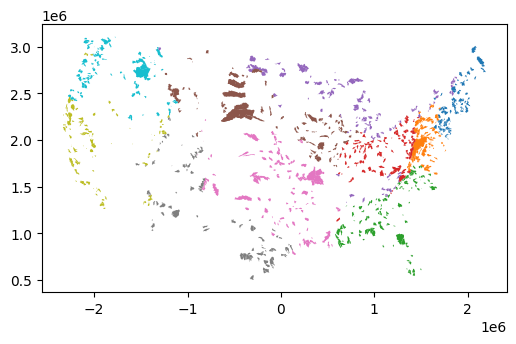

In [81]:
regions_df = CAMELS_basins
region_name = 'name'
regions_df.plot(column=region_name, figsize=(6,4))

Coordinate reference system setting up

In [163]:
regions_df = regions_df.to_crs('EPSG:4326')


In [164]:
crs_orig =  regions_df.crs

In [165]:
x = 'x'  # projected x coordinate name
y = 'y'  # projected y coordinate name

In [166]:
ds = Sandfor_AET
crs_info = ds.crs
xx = ds.x.values
yy = ds.y.values
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
lcc = ccrs.LambertConformal(globe=globe,
                            central_longitude=crs_info.longitude_of_central_meridian, 
                            central_latitude=crs_info.latitude_of_projection_origin,
                            standard_parallels=crs_info.standard_parallel)

lcc_wkt = lcc.to_wkt()

regions_df = regions_df.to_crs(lcc_wkt)

Projection to Lambert Comformal

**Spatial aggregation**

Bounding box for computational boundaries definition 

import xarray as xr
import numpy as np
import pyproj

# ✅ Step 1: Extract projection info from `Sandfor_AET`
if "crs_wkt" in Sandfor_AET.attrs:
    crs_wkt = Sandfor_AET.attrs["crs_wkt"]  # If stored in attributes
elif "crs" in Sandfor_AET:
    crs_wkt = Sandfor_AET["crs"].attrs["crs_wkt"]  # If stored as a coordinate
else:
    raise ValueError("❌ No valid CRS information found in `Sandfor_AET`!")

proj = pyproj.Proj(crs_wkt)  # Use the extracted CRS WKT

# ✅ Step 2: Get the x, y coordinates
x = Sandfor_AET["x"].values
y = Sandfor_AET["y"].values

# ✅ Step 3: Create 2D meshgrid of x, y
X, Y = np.meshgrid(x, y)

# ✅ Step 4: Convert to lat/lon using pyproj
lon, lat = proj(X, Y, inverse=True)  # Convert from projection to WGS84 (lon, lat)

# ✅ Step 5: Assign `lon` and `lat` as coordinates in `Sandfor_AET`
Sandfor_AET = Sandfor_AET.assign_coords(lon=(("y", "x"), lon), lat=(("y", "x"), lat))

# ✅ Step 6: Verify that `lon` and `lat` are added in coordinates
print(Sandfor_AET)

print("✅ `lon` and `lat` successfully added to `Sandfor_AET`!")

# Ensure lon and lat are properly shaped
lon_corrected = Sandfor_AET["lon"].isel(time=0, drop=True)  # Drop time dimension if it exists
lat_corrected = Sandfor_AET["lat"].isel(time=0, drop=True)  # Drop time dimension if it exists

# Update Sandfor_AET with corrected lon/lat
Sandfor_AET = Sandfor_AET.assign_coords(lon=lon_corrected, lat=lat_corrected)


Sandfor_AET.hvplot.quadmesh(x='lon', y='lat', rasterize=True, geo=True, tiles='OSM', alpha=0.7, cmap='turbo')

In [167]:
bbox = tuple(regions_df.total_bounds)
print("Bounding box (xmin, ymin, xmax, ymax):", bbox)

Bounding box (xmin, ymin, xmax, ymax): (-2157580.486584979, -1276762.9967255006, 2300165.6575718042, 1283587.4910916877)


In [168]:
# Extract bounding box from xarray dataset
xmin = Sandfor_AET.x.min().item()
xmax = Sandfor_AET.x.max().item()
ymin = Sandfor_AET.y.min().item()
ymax = Sandfor_AET.y.max().item()

# Print bounding box
bbox = (xmin, ymin, xmax, ymax)
print("Bounding Box (xmin, ymin, xmax, ymax):", bbox)

Bounding Box (xmin, ymin, xmax, ymax): (-124.71540753383657, 24.94648311174839, -66.97196520541397, 49.38054707150407)


In [169]:
bbox = tuple(regions_df.total_bounds)
bbox

(-2157580.486584979,
 -1276762.9967255006,
 2300165.6575718042,
 1283587.4910916877)

Slicing using the bounding box

In [159]:
# ds = ds.sel(x=slice(bbox[0],bbox[2]), y=slice(bbox[1],bbox[3]))
ds = ds.sel(x=slice(bbox[1],bbox[3]), y=slice(bbox[0],bbox[2]))
ds

<xarray.Dataset> Size: 13kB
Dimensions:    (time: 20, y: 0, x: 1608)
Coordinates:
  * x          (x) float64 13kB -124.7 -124.7 -124.6 ... -67.04 -67.01 -66.97
  * y          (y) float64 0B 
  * time       (time) int32 80B 1990 1991 1992 1993 1994 ... 2006 2007 2008 2009
    metpy_crs  object 8B Projection: lambert_conformal_conic
    crs        int32 4B 0
Data variables:
    AET        (time, y, x) float32 0B

Band and gridding

In [119]:
var = "AET"

In [120]:
grid = ds[[var]].drop(['time', var]).reset_coords().load()
grid

C:\Users\adi10136\AppData\Local\Temp\ipykernel_56068\3735952135.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  grid = ds[[var]].drop(['time', var]).reset_coords().load()


<xarray.Dataset> Size: 18kB
Dimensions:    (x: 1608, y: 681)
Coordinates:
  * x          (x) float64 13kB -124.7 -124.7 -124.6 ... -67.04 -67.01 -66.97
  * y          (y) float64 5kB 49.38 49.34 49.31 49.27 ... 25.02 24.98 24.95
Data variables:
    metpy_crs  object 8B Projection: lambert_conformal_conic
    crs        int32 4B 0

In [121]:
grid = grid.cf.add_bounds([x, y]) 

In [122]:
points = grid.stack(point=(y,x))

Bounds conversion to polygon

In [123]:
def bounds_to_poly(x_bounds, y_bounds):
    return Polygon([
        (x_bounds[0], y_bounds[0]),
        (x_bounds[0], y_bounds[1]),
        (x_bounds[1], y_bounds[1]),
        (x_bounds[1], y_bounds[0])
    ])

In [124]:
%%time
boxes = xr.apply_ufunc(
    bounds_to_poly,
    points.x_bounds,
    points.y_bounds,
    input_core_dims=[("bounds",),  ("bounds",)],
    output_dtypes=[np.dtype('O')],
    vectorize=True
)

CPU times: total: 28.8 s
Wall time: 30.3 s


In [125]:
grid_df= gpd.GeoDataFrame(
    data={"geometry": boxes.values, "y": boxes[y], "x": boxes[x]},
    index=boxes.indexes["point"],
    crs=lcc_wkt
)

In [126]:
crs_area = "EPSG:6931"

regions_df = regions_df.to_crs(crs_area)
grid_df = grid_df.to_crs(crs_area)

grid_df.crs

<Projected CRS: EPSG:6931>
Name: WGS 84 / NSIDC EASE-Grid 2.0 North
Axis Info [cartesian]:
- X[south]: Easting (metre)
- Y[south]: Northing (metre)
Area of Use:
- name: Northern hemisphere.
- bounds: (-180.0, 0.0, 180.0, 90.0)
Coordinate Operation:
- name: US NSIDC EASE-Grid 2.0 North
- method: Lambert Azimuthal Equal Area
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [127]:
overlay = grid_df.overlay(regions_df, keep_geom_type=True)

In [128]:
overlay.geometry.area.groupby(overlay[region_name]).sum().nlargest(10)/1e6  # km2
regions_df.geometry.area.groupby(regions_df[region_name]).sum().nlargest(10)

name
06452000    2.554604e+10
01619500    1.612385e+10
13340000    1.427006e+10
06447000    1.272204e+10
06360500    1.266154e+10
06354000    1.053560e+10
06934000    8.264160e+09
06441500    8.136464e+09
06191500    6.782220e+09
07301500    6.253081e+09
dtype: float64

In [129]:
grid_cell_fraction = overlay.geometry.area.groupby(overlay[region_name]).transform(lambda x: x / x.sum())
grid_cell_fraction
grid_cell_fraction.groupby(overlay[region_name]).sum()

name
06876700    1.0
dtype: float64

In [130]:
multi_index = overlay.set_index([y, x, region_name]).index
df_weights = pd.DataFrame({"weights": grid_cell_fraction.values}, index=multi_index)

In [131]:
ds_weights = xr.Dataset(df_weights)

Aggregate duplicate entries by taking the mean (or sum, as required)

In [132]:
ds_weights_aggregated = ds_weights.groupby('dim_0').mean()

Proceed with unstacking

In [133]:
weights_sparse = ds_weights_aggregated.unstack(sparse=True, fill_value=0.)
weights_sparse = weights_sparse.weights

Sparse the matrix

In [134]:
def apply_weights_matmul_sparse(weights, data):

    assert isinstance(weights, sparse.SparseArray)
    assert isinstance(data, np.ndarray)
    data = sparse.COO.from_numpy(data)
    data_shape = data.shape
    # k = nlat * nlon
    n, k = data_shape[0], data_shape[1] * data_shape[2]
    data = data.reshape((n, k))
    weights_shape = weights.shape
    k_, m = weights_shape[0] * weights_shape[1], weights_shape[2]
    assert k == k_
    weights_data = weights.reshape((k, m))

    regridded = sparse.matmul(data, weights_data)
    assert regridded.shape == (n, m)
    return regridded.todense()

In [135]:
%%time
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    var_regridded = xr.apply_ufunc(
        apply_weights_matmul_sparse,
        weights_sparse,
        ds[var],
        join="left",
        input_core_dims=[[y, x, region_name], [y, x]],
        output_core_dims=[[region_name]],
        dask="parallelized",
        dask_gufunc_kwargs=dict(meta=[np.ndarray((0,))])
    )


var_regridded.compute()

CPU times: total: 5.34 s
Wall time: 6.66 s


<xarray.DataArray (time: 20, name: 1)> Size: 160B
array([[-1.43870038e+38],
       [-1.43870038e+38],
       [-1.43870038e+38],
       [-1.43870038e+38],
       [-1.43870038e+38],
       [-1.43870038e+38],
       [-1.43859783e+38],
       [-1.43859783e+38],
       [-1.43859783e+38],
       [-1.43859783e+38],
       [-1.43859783e+38],
       [-1.43863512e+38],
       [-1.43863512e+38],
       [-1.43863512e+38],
       [-1.43863512e+38],
       [-1.43863512e+38],
       [-1.43862580e+38],
       [-1.43862580e+38],
       [-1.43862580e+38],
       [-1.43862580e+38]])
Coordinates:
  * name       (name) object 8B '06876700'
  * time       (time) int32 80B 1990 1991 1992 1993 1994 ... 2006 2007 2008 2009
    metpy_crs  object 8B Projection: lambert_conformal_conic
    crs        int32 4B 0

Runoff Plot

In [136]:
ds_var = var_regridded.sel(name = gage_ids).to_dataset(region_name)

KeyError: "not all values found in index 'name'"

In [ ]:
ds_var.hvplot(x='time', grid=True, frame_width=1000, title='Runoff') 

In [ ]:
df_mean = var_regridded.sel(name= gage_ids).to_pandas().max()
df_mean.name = var
df_mean = pd.DataFrame(df_mean).reset_index()
print(df_mean.columns)

In [ ]:
merged = pd.merge(regions_df, df_mean)

In [ ]:
crs_geo = 'EPSG:4326'

In [ ]:
merged_geo = merged.to_crs(crs_geo)

In [ ]:
merged_geo.hvplot(c=var, geo=True, cmap='viridis_r', frame_width=1000, tiles='OpenTopoMap', title='CAMELS_Runoff_CONUS404', alpha=0.3)

**CAMELS runoff data from CONUS404 to CSV file**

In [ ]:
var_regridded.name = var
CAMELS_Runoff = var_regridded.sel(name = gage_ids)
CAMELS_Runoff = CAMELS_Runoff.sel(time=slice('1989-10-01','2010-09-30')) #.resample(time="Y").sum()
CAMELS_Runoff = CAMELS_Runoff.to_dataframe().reset_index()

df_squaw_creek_Q_data = CAMELS_Runoff

In [ ]:
CAMELS_Runoff.to_csv('838_runoff_CONUS404_2X.csv')

#### **Reading USGS stream data from NLDI**

In [ ]:
# List of USGS gage IDs
gage_ids = ['10011500', '10032000', '10109000', '10128500', '10131000', '10134500', '10137500', '10173450', '10174500', '01019000', '10194200', '10205030', '01022500', '10234500', '10242000', '10258500', '10293000', '10296000', '10296500', '10308200', '10309000', '10310000', '01031500', '10329500', '10344400', '10344500', '10349300', '10352500', '01038000', '10396000', '01047000', '01052500', '01054200', '01055000', '01057000', '01064500', '01073500', '01078000', '01094500', '01096000', '01097000', '11012500', '11015000', '01102000', '11022480', '11025500', '11028500', '11042400', '01104500', '11065000', '11073360', '11077500', '01109000', '01109060', '11109600', '01111500', '11118500', '11123000', '11123500', '11124500', '11132500', '11143000', '11143200', '11143250', '11147500', '11149900', '11151300', '11152000', '11156500', '01116000', '11160000', '11160500', '11162500', '01116500', '11176400', '11176500', '01118500', '01119500', '11200800', '11224500', '11253310', '11264500', '11266500', '11274500', '11274630', '01127500', '01129200', '01134500', '11345500', '01137500', '11376550', '11379500', '11381500', '11383500', '01139000', '11390000', '11402000', '11413000', '11424000', '11427000', '11458000', '11461000', '11468000', '11468500', '11478500', '11481200', '11482500', '01151500', '11521500', '11523200', '01152500', '01166500', '01168500', '01169000', '01170100', '01171500', '01174500', '01176000', '01181000', '01185500', '01186000', '01186500', '01193500', '01196500', '01197000', '01197500', '12010000', '12013500', '12020000', '12025000', '12035000', '12036000', '01204000', '12041200', '12054000', '01208500', '12086500', '12092000', '12093500', '12112600', '12141300', '12142000', '12144500', '12147500', '12148500', '12167000', '12175500', '12186000', '12332000', '12335500', '12342500', '12390700', '12411000', '12414900', '12451000', '12452800', '12502500', '13011900', '13052200', '13075000', '13083000', '13120000', '01315000', '13161500', '13174500', '13200000', '13239000', '13313000', '01331500', '01333000', '13331500', '01334000', '13345000', '01336000', '01350000', '01367500', '01372500', '01380500', '01388000', '01388500', '01391500', '01395000', '01396800', '01397000', '01400000', '01401000', '01402000', '14020000', '14034500', '01405400', '01408000', '01408500', '01409400', '01410000', '01411000', '01411500', '14123500', '14137000', '14145500', '14151000', '14154500', '14155500', '14159500', '14162200', '14165000', '14170000', '14178000', '14185000', '14185900', '14190500', '14203500', '01420500', '14226500', '14236200', '01429000', '01429500', '14301500', '14305500', '14306500', '14309000', '14309500', '01431500', '14316700', '14337500', '14338000', '14362000', '14377100', '01439500', '01440000', '14400000', '01442500', '01445500', '01447500', '01447720', '01449360', '01450500', '01451500', '01452000', '01452500', '01457000', '01464000', '01464500', '01465500', '01467000', '01467048', '01469500', '01470500', '01472157', '01473000', '01474000', '01477000', '01479000', '01480000', '01480500', '01485500', '01487000', '01491000', '01495000', '01500000', '01509000', '01510000', '01523500', '01524500', '01532000', '01534000', '01536000', '01538000', '01539000', '01541000', '01541200', '01541500', '01543000', '01544000', '01545000', '01545600', '01546500', '01547500', '01547700', '01547950', '01555000', '01555500', '01556000', '01558000', '01560000', '01564500', '01568000', '01571500', '01573000', '01574500', '01576500', '01580000', '01582000', '01583500', '01586000', '01595200', '01596500', '01599000', '01601500', '01604500', '01607500', '01616500', '01619500', '01625000', '01626000', '01632000', '01632900', '01634500', '01635500', '01637500', '01639000', '01643500', '01645000', '01646000', '01648000', '01649500', '01651000', '01653600', '01666500', '01673800', '01674000', '02013000', '02014000', '02017500', '02018000', '02021500', '02027000', '02027500', '02028500', '02039000', '02039500', '02041000', '02042500', '02044500', '02046000', '02053200', '02053500', '02053800', '02054500', '02058400', '02059500', '02064000', '02065500', '02069700', '02070000', '02073000', '02074500', '02077200', '02081500', '02082950', '02085500', '02088000', '02090380', '02091000', '02092500', '02094500', '02100500', '02111180', '02111500', '02112120', '02112360', '02113000', '02113850', '02114450', '02118000', '02118500', '02125000', '02133500', '02138500', '02143000', '02143500', '02146600', '02149000', '02152100', '02169570', '02178400', '02212600', '02213500', '02245500', '02246000', '02327100', '02331600', '02333500', '02335700', '02336300', '02337000', '02341800', '02342500', '02344500', '02344700', '02349900', '02369800', '02374500', '02380500', '02385800', '02398000', '02399200', '02401390', '02450000', '02450250', '02464000', '02471001', '02472500', '02473500', '02475500', '02476500', '02476600', '02479130', '02479155', '02481000', '02484000', '03011800', '03014500', '03015500', '03020500', '03028000', '03034000', '03034500', '03038000', '03042000', '03042280', '03042500', '03045000', '03049000', '03053500', '03061500', '03066000', '03070500', '03072000', '03074500', '03076500', '03076600', '03078000', '03079000', '03080000', '03085500', '03091500', '03093000', '03102850', '03106000', '03108000', '03110000', '03111500', '03112000', '03117500', '03118000', '03118500', '03136500',
                       '03145000', '03157000', '03159540', '03161000', '03165000', '03167000', '03170000', '03173000', '03180500', '03186500', '03202400', '03207800', '03208500', '03208950', '03209000', '03217000', '03220000', '03228500', '03232500', '03238500', '03240000', '03241500', '03262000', '03264000', '03272000', '03275600', '03280700', '03281100', '03283500', '03285000', '03294000', '03302800', '03303300', '03310300', '03320500', '03324000', '03325500', '03329700', '03330500', '03333450', '03334500', '03340800', '03342500', '03343400', '03346000', '03347000', '03350700', '03351500', '03353500', '03358000', '03361650', '03361850', '03362000', '03363500', '03364500', '03366500', '03369500', '03375500', '03378000', '03378550', '03378635', '03382100', '03384450', '03438000', '03439000', '03446000', '03451000', '03456500', '03459500', '03460000', '03463300', '03471500', '03479000', '03488000', '03491000', '03498500', '03500000', '03500240', '03504000', '03512000', '03531500', '03550000', '03574500', '03612000', '04027500', '04036000', '04037500', '04040500', '04063700', '04087120', '04087220', '04093000', '04094000', '04096405', '04099510', '04101800', '04102700', '04105000', '04105700', '04108600', '04108800', '04109000', '04112500', '04117500', '04121300', '04128990', '04142000', '04155000', '04161540', '04164500', '04166500', '04168000', '04180000', '04186500', '04189000', '04196800', '04201500', '04202000', '04207200', '04214500', '04215500', '04230500', '04234000', '04239000', '04243500', '04252500', '04256000', '04258000', '04262500', '04280000', '04282000', '04285500', '04287000', '04288000', '04289000', '04292000', '04296000', '04296500', '05017500', '05078230', '05087500', '05101000', '05130500', '05315000', '05370000', '05393500', '05394500', '05397500', '05399500', '05406500', '05408000', '05413500', '05414820', '05419000', '05429500', '05431486', '05444000', '05451900', '05452200', '05454300', '05458000', '05463000', '05466000', '05470500', '05481950', '05487980', '05489000', '05495500', '05501000', '05506800', '05512500', '05516500', '05522500', '05527800', '05529000', '05536000', '05536190', '05536275', '05536290', '05539000', '05540095', '05540500', '05543830', '05548280', '05551200', '05551700', '05556500', '05568800', '05577500', '05579500', '05580000', '05587900', '05593575', '05593900', '05594450', '06061500', '06154400', '06169500', '06211000', '06211500', '06216000', '06280300', '06289000', '06298000', '06309200', '06332515', '06339100', '06342260', '06342450', '06344600', '06402000', '06402500', '06406000', '06410500', '06422500', '06431500', '06447500', '06449000', '06478540', '06478690', '06600100', '06625000', '06632400', '06647500', '06712000', '06800000', '06803000', '06803510', '06803520', '06804000', '06806500', '06814000', '06853800', '06871500', '06876700', '06878000', '06884200', '06888500', '06889500', '06893500', '06894000', '06903400', '06903700', '06910800', '06911900', '06912500', '06915000', '06917000', '06918440', '06918460', '06918740', '06921070', '06921200', '06932000', '07017200', '07050700', '07060710', '07103700', '07126200', '07145700', '07167500', '07169800', '07179500', '07179795', '07180500', '07184000', '07191220', '07196900', '07197000', '07203000', '07207000', '07207500', '07208500', '07216500', '07218000', '07230000', '07247500', '07249400', '07261000', '07264000', '07274000', '07283000', '07291000', '07295000', '07299670', '07301410', '07315200', '07325800', '07326000', '07335700', '07337900', '07340300', '07343000', '07346045', '07352000', '07361500', '07362100', '07373000', '07376500', '07383500', '08017200', '08017300', '08019500', '08028000', '08029500', '08041700', '08061540', '08063100', '08063800', '08064700', '08065200', '08066170', '08066200', '08066300', '08069000', '08070000', '08070500', '08074500', '08076000', '08083100', '08104900', '08109700', '08109800', '08110100', '08150800', '08158600', '08164300', '08164800', '08171000', '08172400', '08178800', '08189700', '08196000', '08198000', '08200000', '08202700', '08255500', '08265000', '08275500', '08276300', '08279000', '08291000', '08378500', '08380500', '08387000', '08401900', '08405500', '09037500', '09047500', '09050100', '09050700', '09059500', '09063000', '09073400', '09080400', '09081600', '09112500', '09124500', '09146200', '09172500', '09210500', '09223000', '09255000', '09277500', '09289500', '09292500', '09310500', '09312600', '09326500', '09330500', '09337500', '09342500', '09352900', '09372000', '09386900', '09390500', '09404450', '09409880', '09430600', '09442680', '09480000', '09497800', '09497980', '09504500', '09505350', '09505800', '09507980', '09510200', '09513780', '09513860']

# Date range for the flow data
start_date = '1979-10-01'
end_date = '2021-09-30'

# Initialize an empty DataFrame to store all gages' data
all_gages_df = pd.DataFrame()

# List to track problematic gage IDs
problematic_gages = []

# Iterate over each gage ID and retrieve its flow data
for gage_id in gage_ids:
    try:
        # Retrieve daily flow data for the specified date range
        flow_data = hf.NWIS(gage_id, 'dv', start_date=start_date, end_date=end_date)
        df = flow_data.df()
        
        # Convert the index to pandas datetime format
        df.index = pd.to_datetime(df.index, errors='coerce')

        # Select the specific column for flow (USGS:gauge_id:00060:00003) and convert to m³/s
        column_name = f'USGS:{gage_id}:00060:00003'
        if column_name in df.columns:
            df[f'{gage_id}'] = df[column_name] * 0.028316  # Conversion factor from ft³/s to m³/s
            all_gages_df = pd.concat([all_gages_df, df[f'{gage_id}']], axis=1)
            print(f"Successfully processed data for Gage ID: {gage_id}")
        else:
            print(f"Column {column_name} not found for Gage ID: {gage_id}")
            problematic_gages.append(gage_id)
    except Exception as e:
        if "upsampled" in str(e):
            print(f"Gage ID {gage_id}: {e} (Upsampled warning)")
        else:
            print(f"Error processing Gage ID {gage_id}: {e}")
        problematic_gages.append(gage_id)

# Remove problematic gage IDs from the list
working_gages = [gage_id for gage_id in gage_ids if gage_id not in problematic_gages]

# Plot the data for working gages
plt.figure(figsize=(12, 8))
for gage_id in working_gages:
    if gage_id in all_gages_df.columns:
        plt.plot(all_gages_df.index, all_gages_df[gage_id], label=gage_id)

# Add labels, title, and legend
plt.title('Flow Rate (m³/s) over Time for Valid Gages')
plt.xlabel('Date')
plt.ylabel('Flow (m³/s)')
plt.legend(title="Gage IDs", loc='upper right', fontsize=8)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

print(f"Problematic Gages: {problematic_gages}")
print(f"Working Gages: {working_gages}")


In [ ]:
all_gages_df
# all_gages_df.to_csv("(CAMELS_USGS_dataDV).csv", index=False)

In [ ]:
# Manually set the index to the expected date range
expected_date_range = pd.date_range(start="1979-10-01", end="2021-09-30", freq="D")

# Ensure the number of rows matches the expected date range
if len(expected_date_range) == all_gages_df.shape[0]:
    all_gages_df.index = expected_date_range
else:
    print("Warning: The number of rows does not match the expected date range!")

# Recompute the percentage of missing values per year across all gages
missing_percentage_by_year = all_gages_df.isna().mean(axis=1) * 100

# Group by year and compute the average missing percentage across all gages
average_missing_percentage_by_year = missing_percentage_by_year.resample('YE').mean()

# Plot the corrected results
plt.figure(figsize=(12, 6))
plt.plot(average_missing_percentage_by_year.index.year, average_missing_percentage_by_year, marker='o', linestyle='-', color='b')

# Formatting the plot
plt.xlabel("Year")

plt.ylabel("Average Missing Data Percentage (%)")
plt.title("Average Percentage of Missing Daily Values Per Year Across All Gages (1979-2021) Sanford - Basins")
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [ ]:
#print(average_missing_percentage_by_year)
# Compute the average missing percentage for the specified year ranges
average_1990_2010 = 100 -average_missing_percentage_by_year.loc["1990":"2010"].mean()
average_1990_2021 =  100 -average_missing_percentage_by_year.loc["1990":"2021"].mean()
average_1979_2021 = 100 -average_missing_percentage_by_year.loc["1979":"2021"].mean()

# Create a DataFrame to display the results
average_missing_summary = pd.DataFrame({
    "Period": ["1990-2010", "1990-2021", "1979-2021"],
    "Average Missing Data Percentage (%)": [average_1990_2010, average_1990_2021, average_1979_2021]
})

# Print the results
print(average_missing_summary)

In [ ]:
import pandas as pd

# Assuming 'all_gages_df' is already loaded

# Count NaN values for each column (gage)
nan_counts = all_gages_df.isna().sum()

# Total number of daily values per column (gage)
total_values_per_gage = all_gages_df.shape[0]

# Calculate percentage of missing values for each gage
missing_percentage_per_gage = (nan_counts / total_values_per_gage) * 100

# Create a DataFrame with the results
missing_data_summary = pd.DataFrame({
    "Gage_ID": all_gages_df.columns,
    "NaN Count": nan_counts.values,
    "Total Values": total_values_per_gage,
    "Missing Percentage (%)": missing_percentage_per_gage.values
})

# Save the results to a CSV file
missing_data_summary.to_csv("Gage_data_Checking(CAMELS).csv", index=False)

# Display the first few rows of the DataFrame
print(missing_data_summary.head())



In [ ]:
# Ensure the index is in datetime format
all_gages_df.index = pd.to_datetime(all_gages_df.index, errors='coerce')

# Resample the data to annual frequency and calculate the mean for each year
annual_flows = all_gages_df.resample("AS-OCT", label="right").mean()

CAMELS Basins Area

In [ ]:
# Ensure the number of gage IDs matches the number of rows in your GeoDataFrame
if len(CAMELS_basins) == len(gage_ids):
    CAMELS_basins['name'] = gage_ids
else:
    raise ValueError("The number of gage IDs does not match the number of features in the shapefile.")

# Reproject to a projected CRS (e.g., EPSG:3857) for accurate area calculations
if CAMELS_basins.crs.is_geographic:
    CAMELS_basins = CAMELS_basins.to_crs(epsg=5070)  # Use Web Mercator or another suitable projected CRS

# Calculate the area in square meters and add it as a new column
CAMELS_basins['Area_sqm'] = CAMELS_basins.geometry.area

Datasets aligment (CONUS404 - USGS)

Plot runoff data

In [ ]:
# Ensure the names in 'CAMELS_basins' match the columns in 'annual_flows'
CAMELS_basins = CAMELS_basins.set_index('name')  # Set gage names as the index for easy matching

# Initialize an empty DataFrame to store annual runoff data
annual_runoff_df = pd.DataFrame()

# Iterate over each gage in the 'annual_flows' DataFrame
for gage_id in annual_flows.columns:
    # Check if the gage ID exists in the huc10_basins DataFrame
    if gage_id in CAMELS_basins.index:
        try:
            # Get the watershed area in square meters for the current gage
            W_A = float(CAMELS_basins.loc[gage_id, 'Area_sqm'])  # Ensure scalar value
            
            # Calculate annual runoff (mm/year) for the gage
            annual_flow = annual_flows[gage_id]  # Annual mean flow (m³/s)
            Annual_Runoff = ((annual_flow.values * 86400 * 365) / W_A) * 1000  # Ensure 1D array
            
            # Create a DataFrame for the current gage's runoff data
            runoff_data = pd.DataFrame({
                'Year': annual_flows.index,  # Use the index (year) from the annual_flows DataFrame
                'Runoff_mm': Annual_Runoff,
                'Gage_ID': gage_id
            })
            
            # Append the gage's runoff data to the final DataFrame
            annual_runoff_df = pd.concat([annual_runoff_df, runoff_data], ignore_index=True)
        except Exception as e:
            print(f"Error processing Gage ID {gage_id}: {e}")
    else:
        print(f"Gage ID {gage_id} not found in huc10_basins. Skipping.")

# Save the final annual runoff data to a CSV file
annual_runoff_df.to_csv('838_annual_runoff2X.csv', index=False)

# Display the first few rows of the final DataFrame
print(annual_runoff_df.head())


In [ ]:
# Plot the annual runoff for all gages
import plotly.express as px

fig = px.line(
    annual_runoff_df,
    x='Year',
    y='Runoff_mm',
    color='Gage_ID',
    title='Annual Runoff (mm/year) for Each Gage',
    labels={'Runoff_mm': 'Runoff (mm/year)', 'Year': 'Year', 'Gage_ID': 'Watershed (Gage ID)'},
)
fig.update_layout(template='plotly_white')
# fig.show()
# Optionally open the file automatically in the default web browser

# Save the plot to an HTML file and open it in the browser
plot_file = "Annual_Runoff.html"
fig.write_html(plot_file)

import webbrowser
webbrowser.open(plot_file)


In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Ensure Gage_ID column exists in both DataFrames
annual_runoff_df.rename(columns={'name': 'Gage_ID'}, inplace=True)
df_squaw_creek_Q_data.rename(columns={'name': 'Gage_ID'}, inplace=True)

# Align both DataFrames to cover the same period (1986-2022) and same Gage_IDs
start_year = '1989-10-01'
end_year = '2010-09-30'

# Filter annual_runoff_df to include only rows in the specified range
annual_runoff_df['Year'] = pd.to_datetime(annual_runoff_df['Year'])
df_squaw_creek_Q_data['time'] = pd.to_datetime(df_squaw_creek_Q_data['time'])

# Filter years and align Gage_IDs
annual_runoff_filtered = annual_runoff_df[
    (annual_runoff_df['Year'] >= start_year) & (annual_runoff_df['Year'] <= end_year)
]

df_squaw_filtered = df_squaw_creek_Q_data[
    (df_squaw_creek_Q_data['time'] >= start_year) & (df_squaw_creek_Q_data['time'] <= end_year)
]

# Get common Gage_IDs
common_gage_ids = set(annual_runoff_filtered['Gage_ID']).intersection(df_squaw_filtered['Gage_ID'])

# Filter both DataFrames to only include common Gage_IDs
annual_runoff_filtered = annual_runoff_filtered[annual_runoff_filtered['Gage_ID'].isin(common_gage_ids)]
df_squaw_filtered = df_squaw_filtered[df_squaw_filtered['Gage_ID'].isin(common_gage_ids)]

In [ ]:
# Convert 'Year' to remove timezone and time portion
annual_runoff_filtered['Year'] = annual_runoff_filtered['Year'].dt.tz_localize(None).dt.normalize()

# Convert 'Year' in annual_runoff_filtered to UTC to match the format of df_squaw_filtered
annual_runoff_filtered['Year'] = annual_runoff_filtered['Year'].dt.tz_localize(None)

# Confirm that both columns are now in the same format
print(annual_runoff_filtered['Year'].dtype)
print(df_squaw_filtered['time'].dtype)

In [ ]:
df_squaw_filtered

In [ ]:
annual_runoff_filtered

In [ ]:
# Merge the DataFrames on Gage_ID and Year/Time
aligned_data = pd.merge(
    annual_runoff_filtered,
    df_squaw_filtered,
    left_on=['Gage_ID', 'Year'],
    right_on=['Gage_ID', 'time'],
    how='inner'
)

# Rename columns for clarity
aligned_data.rename(columns={'Runoff_mm': 'Runoff_Annual', 'Runoff': 'Runoff_Squaw'}, inplace=True)

In [ ]:
# print(aligned_data)
aligned_data.to_csv('838_annual_runoffCONUS404-USGS.csv', index=False)

In [ ]:
# Drop rows with NaN values in either 'Runoff_Annual' or 'Runoff_Squaw'
aligned_data = aligned_data.dropna(subset=['Runoff_Annual', 'Runoff_Squaw'])

# # Confirm there are no NaN values left
# print(aligned_data.isnull().sum())

Bias error and Root Mean Square Error calculation

In [ ]:
# Define functions for Bias (BA) and RMSE
def calculate_bias(true_values, predicted_values):
    """Calculate Bias (Systematic Error)."""
    return np.mean(predicted_values - true_values)

def calculate_rmse(true_values, predicted_values):
    """Calculate Root Mean Square Error (RMSE)."""
    return np.sqrt(np.mean((predicted_values - true_values) ** 2))

# Group by Gage_ID and compute BA and RMSE
results = []
for gage_id, group in aligned_data.groupby('Gage_ID'):
    true_values = group['Runoff_Annual']  # USGS Data (True)
    predicted_values = group['Runoff_Squaw']  # CONUS404 Data (Modeled)

    ba = calculate_bias(true_values, predicted_values)
    rmse = calculate_rmse(true_values, predicted_values)

    results.append({'Gage_ID': gage_id, 'Bias (BA)': ba, 'RMSE': rmse})

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display the results
# !pip install ace_tools
# import ace_tools as tools
# tools.display_dataframe_to_user(name="Bias and RMSE Results", dataframe=results_df)

# Optional: Save the results
results_df.to_csv('BE_RMSE_Sanford.csv', index=False)

**Individual Scatter plots**

In [ ]:
# Function to create scatter plots with linear regression
def plot_scatter_with_regression(data, gage_id, output_folder):
    # Filter data for the specific Gage_ID
    gage_data = data[data['Gage_ID'] == gage_id]

    # Extract X (annual runoff) and Y (squaw creek runoff)
    X = gage_data['Runoff_Annual'].values.reshape(-1, 1)
    Y = gage_data['Runoff_Squaw'].values

    # Perform linear regression
    model = LinearRegression()
    model.fit(X, Y)
    Y_pred = model.predict(X)
    r_squared = model.score(X, Y)

    # Plot scatter and regression line
    plt.figure(figsize=(8, 6))
    plt.scatter(X, Y, color='blue', label='Data points')
    plt.plot(X, Y_pred, color='red', label=f'Linear Regression\ny = {model.coef_[0]:.2f}x + {model.intercept_:.2f}')
    plt.title(f'Scatter Plot: {gage_id} (1986-2022)')
    plt.xlabel('Annual Runoff USGS(mm)')
    plt.ylabel('Annual Runoff CONUS404(mm)')
    plt.legend()
    plt.grid(True)
    plt.text(0.05, 0.95, f'R² = {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

    # Save the plot in the specified folder
    filename = os.path.join(output_folder, f"{gage_id}_scatter_plot.png")
    plt.savefig(filename, format="png")
    plt.close()  # Close the figure to save memory
    print(f"Scatter plot saved for Gage ID: {gage_id} at {filename}")

# Specify the output folder to store scatter plots
output_folder = "838_Scatter_polts"
os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist
            
# Loop through each Gage_ID and save plots
for gage_id in common_gage_ids:
    plot_scatter_with_regression(aligned_data, gage_id, output_folder)

**Data frame with values for coefficient of determination**

In [ ]:
# List to store results
results = []

# Loop through each Gage_ID and compute regression statistics
for gage_id in common_gage_ids:
    # Filter data for the specific Gage_ID
    gage_data = aligned_data[aligned_data['Gage_ID'] == gage_id]

    # Extract X (annual runoff) and Y (squaw creek runoff)
    X = gage_data['Runoff_Annual'].values.reshape(-1, 1)
    Y = gage_data['Runoff_Squaw'].values

    # Perform linear regression
    model = LinearRegression()
    model.fit(X, Y)
    r_squared = model.score(X, Y)

    # Store results
    results.append({
        'Gage_ID': gage_id,
        'R_Squared': r_squared,
        'Slope': model.coef_[0],
        'Intercept': model.intercept_
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Save to CSV
csv_filename = "gage_regression_results_838_2X.csv"
results_df.to_csv(csv_filename, index=False)

print(f"CSV file saved as {csv_filename}")
print(results_df.head())  # Display first few rows of the DataFrame

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Function to create scatter plots with linear regression for a single gage
def plot_scatter_with_regression(data, gage_id):
    # Filter data for the specific Gage_ID
    gage_data = data[data['Gage_ID'] == gage_id]

    # Extract X (annual runoff) and Y (squaw creek runoff)
    X = gage_data['Runoff_Annual'].values.reshape(-1, 1)
    Y = gage_data['Runoff_Squaw'].values

    # Perform linear regression
    model = LinearRegression()
    model.fit(X, Y)
    Y_pred = model.predict(X)
    r_squared = model.score(X, Y)

    return gage_id, X, Y, Y_pred, r_squared, model

# Function to create a multi-panel plot for gages with R² > 0.7, remove grid lines, and save as PNG
def plot_filtered_scatter(data, common_gage_ids, output_file='filtered_scatter_plots.png'):
    # Filter gage IDs with R² > 0.7
    filtered_gages = []
    results = []
    
    for gage_id in common_gage_ids:
        gage_id, X, Y, Y_pred, r_squared, model = plot_scatter_with_regression(data, gage_id)
        if r_squared > 0.7:
            filtered_gages.append(gage_id)
            results.append((X, Y, Y_pred, r_squared, gage_id, model))

    # Create a multi-panel figure
    n = len(filtered_gages)
    cols = 2
    rows = (n + 1) // cols  # Calculate the number of rows needed
    fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))
    axes = axes.flatten() if n > 1 else [axes]

    for i, (X, Y, Y_pred, r_squared, gage_id, model) in enumerate(results):
        ax = axes[i]
        ax.scatter(X, Y, color='blue', label='Data points')
        ax.plot(X, Y_pred, color='red', label=f'Linear Regression\ny = {model.coef_[0]:.2f}x + {model.intercept_:.2f}')
        ax.set_title(f'{gage_id}: R² = {r_squared:.2f}')
        ax.set_xlabel('Annual Runoff USGS(mm)')
        ax.set_ylabel('Annual Runoff CONUS404(mm)')
        ax.legend()
        # Remove grid lines
        ax.grid(False)

    # Hide unused subplots if any
    for j in range(len(results), len(axes)):
        axes[j].axis('off')

    # Adjust layout and save to a file
    plt.tight_layout()
    plt.savefig(output_file, dpi=600)
    plt.close()

    print(f"Scatter plots saved to {output_file}")

# Example usage (Replace `aligned_data` and `common_gage_ids` with your actual data)
plot_filtered_scatter(aligned_data, common_gage_ids, output_file='camels_scatter_plots_filtered_838.png')


**Scatter plots filtered by number of points and value for coefficient of determination**

In [ ]:
# Adding a filter to include only gages with more than 20 points
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Function to create scatter plots with linear regression for a single gage
  def plot_scatter_with_regression(data, gage_id):
    # Filter data for the specific Gage_ID
    gage_data = data[data['Gage_ID'] == gage_id]

    # Extract X (annual runoff) and Y (squaw creek runoff)
    X = gage_data['Runoff_Annual'].values.reshape(-1, 1)
    Y = gage_data['Runoff_Squaw'].values

    # Perform linear regression
    model = LinearRegression()
    model.fit(X, Y)
    Y_pred = model.predict(X)
    r_squared = model.score(X, Y)

    return gage_id, X, Y, Y_pred, r_squared, model, len(X)

# Function to create a grid layout of scatter plots with filtering
def plot_scatter_grid(data, common_gage_ids, scatter_width=4, scatter_height=3, output_file='scatter_grid_poster_838.png'):
    # Filter gage IDs with R² > 0.7 and more than 20 points
    filtered_gages = []
    results = []

    for gage_id in common_gage_ids:
        gage_id, X, Y, Y_pred, r_squared, model, num_points = plot_scatter_with_regression(data, gage_id)
        if r_squared > 0.85 and num_points > 15:  # Apply both filters
            filtered_gages.append(gage_id)
            results.append((X, Y, Y_pred, r_squared, gage_id, model))

    # Determine the number of rows and columns
    n = len(filtered_gages)
    cols = 4  # Adjust as needed for poster layout
    rows = (n + cols - 1) // cols  # Calculate number of rows

    # Set figure size based on scatter plot dimensions
    fig, axes = plt.subplots(rows, cols, figsize=(scatter_width * cols, scatter_height * rows))  # Flexible size
    axes = axes.flatten() if n > 1 else [axes]

    for i, (X, Y, Y_pred, r_squared, gage_id, model) in enumerate(results):
        ax = axes[i]
        ax.scatter(X, Y, color='black', alpha=0.7, s=9, label='Data points')  
        ax.plot(X, Y_pred, color='blue', label=f'Fit: y={model.coef_[0]:.2f}x+{model.intercept_:.2f}')
        ax.plot([min(X), max(X)], [min(X), max(X)], linestyle='--', color='gray', label='1:1 Line')
        ax.set_title(f'Gage: {gage_id}\nR² = {r_squared:.2f}', fontsize=18)
        ax.set_xlabel('USGS Runoff (mm)', fontsize=16)
        ax.set_ylabel('CONUS404 Runoff (mm)', fontsize=16)
        ax.tick_params(axis='y', which='major', labelsize=14) 
        ax.tick_params(axis='x', which='major', labelsize=14)  
        ax.legend(fontsize=12, loc='lower right')  

    # Hide unused subplots if any
    for j in range(len(results), len(axes)):
        axes[j].axis('off')

    # Adjust layout for poster presentation
    plt.tight_layout(pad=2.0)
    plt.savefig(output_file, dpi=600)
    plt.close()

    print(f"Scatter grid saved to {output_file}")

# Example usage (Replace `aligned_data` and `common_gage_ids` with your actual data)
plot_scatter_grid(aligned_data, common_gage_ids, scatter_width=5, scatter_height=4, output_file='CAMELS_scatter_grid_poster_838.png')
